## Q1

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import math
from sklearn.cross_validation import train_test_split
from sklearn import tree
import numpy as np
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt

%matplotlib inline

data_file='loans data.csv'
ld=pd.read_csv(data_file)


for col in ["Interest.Rate","Debt.To.Income.Ratio"]:
    ld[col]=ld[col].astype("str")
    ld[col]=[x.replace("%","") for x in ld[col]]

for col in ["Amount.Requested","Amount.Funded.By.Investors","Open.CREDIT.Lines",
            "Revolving.CREDIT.Balance",
           "Inquiries.in.the.Last.6.Months","Interest.Rate","Debt.To.Income.Ratio"]:
    ld[col]=pd.to_numeric(ld[col],errors="coerce")


ld["LL_36"]=np.where(ld['Loan.Length']=="36 months",1,0)
ld.drop('Loan.Length',axis=1,inplace=True)


for i in range(len(ld.index)):
    if ld["Loan.Purpose"][i] in ["car","educational","major_purchase"]:
        ld.loc[i,"Loan.Purpose"]="cem"
    if ld["Loan.Purpose"][i] in ["home_improvement","medical","vacation","wedding"]:
        ld.loc[i,"Loan.Purpose"]="hmvw"
    if ld["Loan.Purpose"][i] in ["credit_card","house","other","small_business"]:
        ld.loc[i,"Loan.Purpose"]="chos"
    if ld["Loan.Purpose"][i] in ["debt_consolidation","moving"]:
        ld.loc[i,"Loan.Purpose"]="dm"

lp_dummies=pd.get_dummies(ld["Loan.Purpose"],prefix="LP")


lp_dummies.drop("LP_renewable_energy",1,inplace=True)


ld=pd.concat([ld,lp_dummies],1)
ld=ld.drop("Loan.Purpose",1)

ld=ld.drop(["State"],1)

ld["ho_mort"]=np.where(ld["Home.Ownership"]=="MORTGAGE",1,0)
ld["ho_rent"]=np.where(ld["Home.Ownership"]=="RENT",1,0)
ld=ld.drop(["Home.Ownership"],1)


ld['f1'], ld['f2'] = zip(*ld['FICO.Range'].apply(lambda x: x.split('-', 1)))

ld["fico"]=0.5*(pd.to_numeric(ld["f1"])+pd.to_numeric(ld["f2"]))

ld=ld.drop(["FICO.Range","f1","f2"],1)

ld["Employment.Length"]=ld["Employment.Length"].astype("str")
ld["Employment.Length"]=[x.replace("years","") for x in ld["Employment.Length"]]
ld["Employment.Length"]=[x.replace("year","") for x in ld["Employment.Length"]]

ld["Employment.Length"]=[x.replace("n/a","< 1") for x in ld["Employment.Length"]]
ld["Employment.Length"]=[x.replace("10+","10") for x in ld["Employment.Length"]]
ld["Employment.Length"]=[x.replace("< 1","0") for x in ld["Employment.Length"]]
ld["Employment.Length"]=pd.to_numeric(ld["Employment.Length"],errors="coerce")

ld.dropna(axis=0,inplace=True)

ld_train, ld_test = train_test_split(ld, test_size = 0.2,random_state=2)

x_train=ld_train.drop(["Interest.Rate","ID","Amount.Funded.By.Investors"],1)
y_train=ld_train["Interest.Rate"]

x_test=ld_test.drop(["Interest.Rate","ID","Amount.Funded.By.Investors"],1)
y_test=ld_test["Interest.Rate"]

C:\Users\patilsh\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We need to reset indices so that we can use the data from kfold cv without index errors

In [2]:
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [3]:
from sklearn.grid_search import GridSearchCV


C:\Users\patilsh\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
import time
start_time = time.time()

param_grid1 = {'max_depth':list(range(20,81,10)),'max_features':list(range(7,16,2)),
               "max_leaf_nodes":list(range(10,100,5))}
grid = GridSearchCV(tree.DecisionTreeRegressor(criterion="mse",random_state=2),param_grid=param_grid1,cv=10)

In [ ]:
grid.fit(x_train,y_train)


print("--- %s seconds ---" % (time.time() - start_time))

Line number 1,2 and 10 have nothing to do with run of your algorithm , we are putting it to time the runtime. For me as you can see it took around ~1 minutes. It will vary for you depending upon your RAM, and backgroun processes running when you are executing this on your machine.

In [101]:
print(grid.best_estimator_)

We'll use this , in our final model as given below

In [8]:
dtree=tree.DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=13,
           max_leaf_nodes=40, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=2,
           splitter='best')

In [9]:
dtree.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=13,
           max_leaf_nodes=40, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=2, splitter='best')

In [10]:
predicted=dtree.predict(x_test)

In [11]:
residual=predicted-y_test

In [12]:
rmse_dtree=np.sqrt(np.dot(residual,residual)/len(predicted))

rmse_dtree

1.9950493736428685

linear regression model with l1 penalty gave us rmse on test:1.9985397126873645, we see a slight improvement with decision trees

## Q2

### Data Prep

In [65]:
data_file='paydayloan_collections.csv'
pdl=pd.read_csv(data_file)


pdl["payment"]=np.where(pdl["payment"]=="Success",1,0)


k=pdl.columns


for col in k:
    if pdl[col].dtype=='object':
        temp=pd.get_dummies(pdl[col],drop_first=True,prefix=col)
        pdl=pd.concat([pdl,temp],1)
        pdl.drop([col],axis=1,inplace=True)


pdl.dropna(axis=0,inplace=True)


pdl_train, pdl_test = train_test_split(pdl, test_size = 0.2,random_state=2)

x_train=pdl_train.drop(["payment"],1)
y_train=pdl_train["payment"]

x_test=pdl_test.drop(["payment"],1)
y_test=pdl_test["payment"]

x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [66]:
x_train.shape

(24000, 62)

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV

In [68]:
params={'n_estimators':[100,200,500,700,1000],
       'criterion':['gini','entropy'],
       'min_samples_split':[5,6,7,8,9,10],
       'bootstrap':[True,False],
       'max_depth':[None,5,10,15,20],
       'max_features':[5,10,15,20,30,40,50],
       'min_samples_leaf':[5,6,7,8,9,10]}

In [69]:
start_time = time.time()
clf=RandomForestClassifier(class_weight="balanced",verbose=1,n_jobs=-1)

n_iter_search = 20


random_search = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=n_iter_search)

In [ ]:
random_search.fit(x_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print(random_search.best_estimator_)

In [70]:
clf=RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='entropy', max_depth=20, max_features=30,
            max_leaf_nodes=None, min_samples_leaf=8, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [21]:
from __future__ import division

(24000, 62)

In [72]:
clf.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='entropy', max_depth=20, max_features=30,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)

In [73]:
predicted=clf.predict(x_test)

df_test=pd.DataFrame(list(zip(y_test,predicted)),columns=["real","predicted"])

k=pd.crosstab(df_test['real'],df_test["predicted"])
print(k)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s


predicted     0     1
real                 
0          3361   401
1           328  1910


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


In [74]:
TP=k.iloc[1,1]
TN=k.iloc[0,0]
FP=k.iloc[0,1]
FN=k.iloc[1,0]
P=TP+FN
N=TN+FP

print('Accuracy is :',(TP+TN)/(P+N))
print('Sensitivity is :',TP/P)
print('Specificity is :',TN/N)

('Accuracy is :', 0.87849999999999995)
('Sensitivity is :', 0.85344057193923151)
('Specificity is :', 0.89340776182881443)


In [98]:
importances = clf.feature_importances_
importances
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, list(x_train.columns)[f], importances[indices[f]]))

Feature ranking:
1. feature var3 (0.437542)
2. feature var4 (0.078551)
3. feature var5 (0.076824)
4. feature var6 (0.047673)
5. feature var7 (0.041158)
6. feature var8 (0.016415)
7. feature var12 (0.016191)
8. feature var14 (0.016094)
9. feature var15 (0.016081)
10. feature var16 (0.015889)
11. feature var18 (0.015869)
12. feature var20 (0.015598)
13. feature var21 (0.015598)
14. feature var22 (0.015452)
15. feature var24 (0.015413)
16. feature var25 (0.015403)
17. feature var26 (0.015324)
18. feature var27 (0.015305)
19. feature var28 (0.015074)
20. feature var30 (0.015017)
21. feature var1_ma (0.014878)
22. feature var1_qw (0.014127)
23. feature var1_wv (0.012473)
24. feature var2_hk (0.011160)
25. feature var2_js (0.004060)
26. feature var2_lo (0.002428)
27. feature var2_py (0.001813)
28. feature var2_qf (0.001622)
29. feature var2_rv (0.001592)
30. feature var2_xn (0.001590)
31. feature var2_zg (0.001558)
32. feature var9_ja (0.001542)
33. feature var9_nv (0.001314)
34. feature var

### partial dependence plot

In [107]:
def part_plot1(data,classf,varname):
    # we need to create a copy otherwise these changes 
    # will reflect in the original data as well
    
    d=data.copy()
    features=d.columns
   
    for f in features:
        if f==varname:pass
        else:
            d[f]=d[f].mean()
    
    d=d.drop_duplicates()
    
    d['response']=pd.Series(list(zip(*classf.predict_proba(d)))[1])
#     print(ggplot(d,aes(x=varname,y='response'))+\
#     xlab(varname)+\
#     ylab('Response')+\
#     ggtitle('Partial Dependence Plot \n Response Vs '+varname))
    import seaborn as sns

In [114]:
def part_plot(data,classf,varname):
    part_dep_data = x_train.groupby([varname]).mean()
    part_dep_data.reset_index(inplace=True)
    part_dep_data['response']=pd.Series(list(zip(*classf.predict_proba(part_dep_data)))[1])
    
    import seaborn as sns
    sns.lmplot(x=varname,y='response',data = part_dep_data, fit_reg=False)
    
    import statsmodels.api as sm
    smooth_data = sm.nonparametric.lowess(part_dep_data['response'],part_dep_data[varname])
    
    df  = pd.DataFrame({'response':smooth_data[:,1], varname:smooth_data[:,0]})
    sns.lmplot(x=varname,y='response',data = df, fit_reg=False)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.

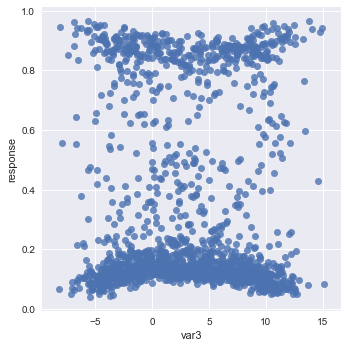

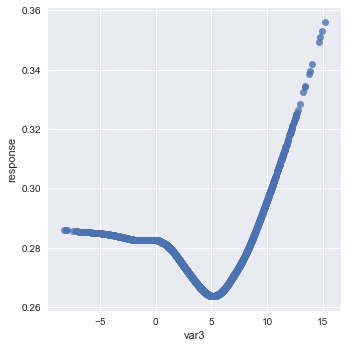

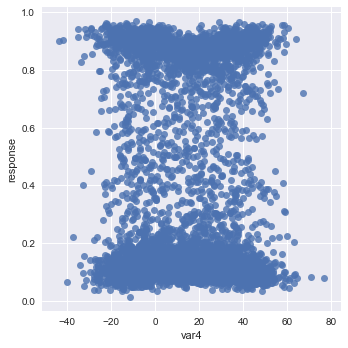

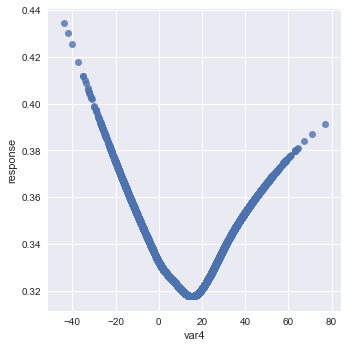

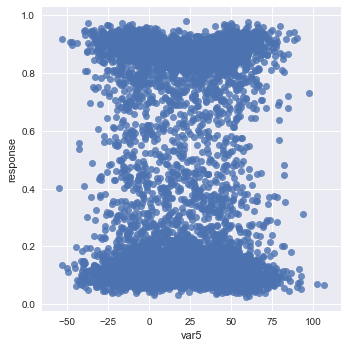

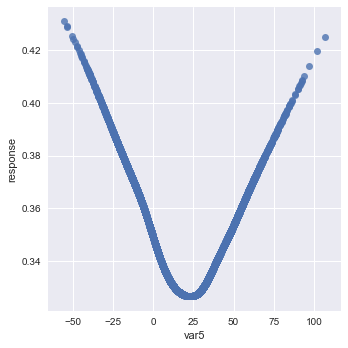

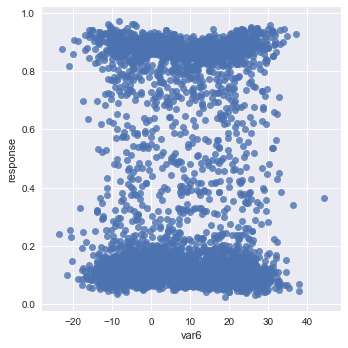

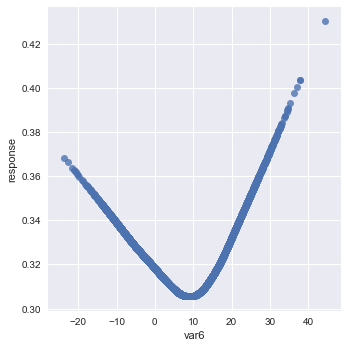

In [115]:
from ggplot import *
part_plot(x_train,clf,'var3')
part_plot(x_train,clf,'var4')
part_plot(x_train,clf,'var5')
part_plot(x_train,clf,'var6')

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

We are not going to tune parameters here , and will rather use parameter values from randomforest run. You should ideally do parameter tuning seaparately

In [27]:

ext=ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
            criterion='entropy', max_depth=20, max_features=30,
            max_leaf_nodes=None, min_samples_leaf=8, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            verbose=1)

In [28]:
ext.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.4s finished


ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='entropy', max_depth=20, max_features=30,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False)

In [29]:
predicted=ext.predict(x_test)

df_test=pd.DataFrame(list(zip(y_test,predicted)),columns=["real","predicted"])

k=pd.crosstab(df_test['real'],df_test["predicted"])
print(k)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s


predicted     0     1
real                 
0          3316   446
1           325  1913


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished


In [30]:
TP=k.iloc[1,1]
TN=k.iloc[0,0]
FP=k.iloc[0,1]
FN=k.iloc[1,0]
P=TP+FN
N=TN+FP

print('Accuracy is :',(TP+TN)/(P+N))
print('Sensitivity is :',TP/P)
print('Specificity is :',TN/N)

('Accuracy is :', 0.87150000000000005)
('Sensitivity is :', 0.85478105451295805)
('Specificity is :', 0.88144603934077614)


In [31]:
importances = ext.feature_importances_
importances


indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, list(x_train.columns)[f], importances[indices[f]]))

Feature ranking:
1. feature var3 (0.518659)
2. feature var4 (0.079270)
3. feature var5 (0.047670)
4. feature var6 (0.034418)
5. feature var7 (0.024674)
6. feature var8 (0.015093)
7. feature var12 (0.013270)
8. feature var14 (0.009859)
9. feature var15 (0.009726)
10. feature var16 (0.008843)
11. feature var18 (0.008437)
12. feature var20 (0.008220)
13. feature var21 (0.007406)
14. feature var22 (0.007291)
15. feature var24 (0.007289)
16. feature var25 (0.007267)
17. feature var26 (0.007259)
18. feature var27 (0.007256)
19. feature var28 (0.007217)
20. feature var30 (0.007165)
21. feature var1_ma (0.007092)
22. feature var1_qw (0.007083)
23. feature var1_wv (0.007074)
24. feature var2_hk (0.007064)
25. feature var2_js (0.007020)
26. feature var2_lo (0.006991)
27. feature var2_py (0.006979)
28. feature var2_qf (0.006943)
29. feature var2_rv (0.006931)
30. feature var2_xn (0.006845)
31. feature var2_zg (0.006765)
32. feature var9_ja (0.006758)
33. feature var9_nv (0.006525)
34. feature var

In [32]:
part_plot(x_train,ext,'var3')
part_plot(x_train,ext,'var4')
part_plot(x_train,ext,'var5')
part_plot(x_train,ext,'var6')

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


NameError: global name 'geom_smooth' is not defined

Although there is not much difference in performances , but do notice the difference in importance and slight changes in the pattern which extraclassfier extracts from the data in comparison to randomForest Classifier

## Q3

### Data Prep

In [33]:
data_file='emissions.csv'
em=pd.read_csv(data_file)

k=em.columns
for col in k:
    if em[col].dtype=='object':
        temp=pd.get_dummies(em[col],drop_first=True,prefix=col)
        em=pd.concat([em,temp],1)
        em.drop([col],axis=1,inplace=True)

em.dropna(axis=0,inplace=True)

em_train, em_test = train_test_split(em, test_size = 0.2,random_state=2)

x_train=em_train.drop(["ppm"],1)
y_train=em_train["ppm"]

x_test=em_test.drop(["ppm"],1)
y_test=em_test["ppm"]

x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)


In [34]:
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer

To use your own scoring function, you need to define your own loss function . This needs to take take two inputs as shown below .

Here x is the real outcome and y is the predicted outcome.

function `make_scorer` converts this to a function which we can pass to GridSearchCV/RandomSearchCV

In [35]:
def loss_func(x, y):return((np.abs(x-y)).mean())
    
my_scorer = make_scorer(loss_func, greater_is_better=False)


In [36]:
start_time = time.time()
rg = RandomForestRegressor(n_jobs=-1,verbose=1)

        
param_dist = {"n_estimators":[10,100,500,700],
              "max_depth": [3,5, None],
              "max_features": sp_randint(5, 11),
              "min_samples_split": sp_randint(5, 11),
              "min_samples_leaf": sp_randint(5, 11),
              "bootstrap": [True, False]}

n_iter_search = 20
random_search = RandomizedSearchCV(rg, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   scoring=my_scorer,
                                   cv=10,
                                   random_state=2)

In [ ]:
random_search.fit(x_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print(random_search.best_estimator_)

In [ ]:
#help(RandomForestRegressor)

In [37]:
rg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=9, max_leaf_nodes=None, min_samples_leaf=8,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, 
           verbose=1, warm_start=False)

In [38]:
rg.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   14.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False)

In [39]:
predicted=rg.predict(x_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.4s finished


In [40]:
residual=predicted-y_test

In [41]:
rmse=np.sqrt(np.dot(residual,residual)/len(predicted))

rmse

19.678278450296727